# Datasets
- [wave_benchmarks.zip](https://ir.library.oregonstate.edu/concern/parent/47429f155/file_sets/jh343z59f)


# 要求
使用[Python Outlier Detection (PyOD)](https://github.com/yzhao062/pyod)或其他已知的工具包来完成分析工作

# 提交的内容
- 完整的分析代码
- 分析报告：展示分析的思路，详细过程，结果及你的分析
- 所选择的数据集在README中说明，数据文件不要上传到Github中


In [1]:
import pandas as pd
import os
import time
import warnings
import numpy as np

warnings.filterwarnings('ignore')

# timekeeping
timekeeping = time.time()

In [2]:
PAGEB_ROOT = 'wave/benchmarks'
benchmark_list = os.listdir(PAGEB_ROOT)
print(len(benchmark_list))

1080


## 数据来源说明

根据论文[1]可知，数据集中会引入4种不同的层次的不相关特征（i.e., noise）。

要创建新的不相关特征，首先从原始母集中随机选择一个特征。 然后，对于原始数据集中的每个数据点，通过从原始数据点的值进行统一采样（替换）来为此特征选择一个值。 结果是新添加的特征与某些原始特征具有相同的边缘分布，但是其值不包含有关数据点异常状态的信息。这保留了真实数据的特质，同时允许引入噪声。

为了简化确定需要多少不相关特征的过程，如果数据集已经具有$d$维特征，而我们想评估$d^{'}$维，即将成对平均距离增加一个因子$\alpha$所需的维数，那么
\begin{equation}
d^{'} = \left( \alpha \sqrt{d}\right)^2 ~ ~ ~ ~(1)\,,
\end{equation}

其中$\alpha \in \{1.0, 1.2, 1.5, 2.0\}$.

[1] Emmott A, Das S, Dietterich T G, et al. A Meta-Analysis of the Anomaly Detection Problem[J]. arXiv: Artificial Intelligence, 2015.

随机选取一个csv文件，确定该数据集的原始特征有哪些？

In [3]:
df = pd.read_csv(os.path.join(PAGEB_ROOT, benchmark_list[0]))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3167 entries, 0 to 3166
Data columns (total 90 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   point.id        3167 non-null   object 
 1   motherset       3167 non-null   object 
 2   origin          3167 non-null   object 
 3   original.label  3167 non-null   int64  
 4   diff.score      3167 non-null   float64
 5   ground.truth    3167 non-null   object 
 6   V               3167 non-null   float64
 7   V.1             3167 non-null   float64
 8   V.2             3167 non-null   float64
 9   V.3             3167 non-null   float64
 10  V.4             3167 non-null   float64
 11  V.5             3167 non-null   float64
 12  V.6             3167 non-null   float64
 13  V.7             3167 non-null   float64
 14  V.8             3167 non-null   float64
 15  V.9             3167 non-null   float64
 16  V.10            3167 non-null   float64
 17  V.11            3167 non-null   f

,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,...,noise..54,noise..55,noise..56,noise..57,noise..58,noise..59,noise..60,noise..61,noise..62,noise..63
0,wave_point_2031,wave,multiclass,2,0.000419,nominal,0.242400,-0.739089,0.460923,0.345094,...,-0.704685,-0.420880,0.989380,0.245247,-0.553928,-0.128014,-0.304973,1.501803,0.931567,-0.022335
1,wave_point_2344,wave,multiclass,0,0.133717,anomaly,0.875982,-0.255060,-1.525660,-0.891447,...,0.353467,0.232501,-0.028837,-1.227749,-0.242542,-1.351196,-0.043533,0.437639,-0.276709,0.232039
2,wave_point_0849,wave,multiclass,2,0.001321,nominal,-0.094190,0.247950,0.090543,-0.863183,...,-1.179651,1.479864,1.491877,0.804384,-0.673693,-0.187520,-0.813721,1.153094,0.599468,-1.386063
3,wave_point_4662,wave,multiclass,0,0.248145,anomaly,0.658188,0.086607,-0.624964,-0.304973,...,-0.530330,0.955180,-0.696628,-0.818917,1.218581,-0.220579,0.027126,0.455675,0.069522,-0.573479
4,wave_point_1214,wave,multiclass,1,0.042073,nominal,0.064206,1.851888,0.317821,1.793612,...,-0.211682,1.430366,-0.438768,-1.774862,0.601796,-0.233802,-1.159953,0.485736,-0.644139,0.832644


根据以上的信息我们可以确定，pageb这个数据集的原始特征维度$d=21$(``V``, ``V.1``~``V.20``)。因此，由等式（1）可知，所有csv文件所包含的列数可能为$27=\left(1.0 \times \sqrt{21}\right)^2+6$, $36=\left(1.2 \times \sqrt{21}\right)^2+6$, $53=\left(1.5 \times \sqrt{21}\right)^2+6$, $90=\left(2.0 \times \sqrt{21}\right)^2+6$.

下面我们遍历所有csv文件，验证一下。

In [4]:
d_set = set()
d_count = 0
for i in range(len(benchmark_list)):
    df = pd.read_csv(os.path.join(PAGEB_ROOT, benchmark_list[i]))
    d_set.add(len(df.columns))
    d_count += len(df)
print('Possible columns of all csv files:', d_set)
print('Total amount:', d_count)

Possible columns of all csv files: {90, 27, 36, 53}
Total amount: 2632953


## 数据特征选择

为了充分利用所提供的数据集完成离群点分析与异常检测，将提取所有csv文件共同的特征（即原始特征,``V``, ``V.1``~``V.20``）作为算法或模型的输入，用于检测该条数据是否属于异常点。

In [5]:
ORIGIN_FEATURES = ['V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.9','V.10', 
                   'V.11', 'V.12', 'V.13', 'V.14', 'V.15', 'V.16', 'V.17', 'V.18', 'V.19', 'V.20',
                   'ground.truth']
def feature_section(benchmark_list):
    concat_data = pd.DataFrame()
    for i in benchmark_list:
        df = pd.read_csv(os.path.join(PAGEB_ROOT, i))
        concat_data = concat_data.append(df[ORIGIN_FEATURES])
    return concat_data

In [6]:
concat_data = feature_section(benchmark_list=benchmark_list)
concat_data.info()
concat_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2632953 entries, 0 to 3009
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   V             float64
 1   V.1           float64
 2   V.2           float64
 3   V.3           float64
 4   V.4           float64
 5   V.5           float64
 6   V.6           float64
 7   V.7           float64
 8   V.8           float64
 9   V.9           float64
 10  V.10          float64
 11  V.11          float64
 12  V.12          float64
 13  V.13          float64
 14  V.14          float64
 15  V.15          float64
 16  V.16          float64
 17  V.17          float64
 18  V.18          float64
 19  V.19          float64
 20  V.20          float64
 21  ground.truth  object 
dtypes: float64(21), object(1)
memory usage: 462.0+ MB


,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.9,...,V.12,V.13,V.14,V.15,V.16,V.17,V.18,V.19,V.20,ground.truth
0,0.242400,-0.739089,0.460923,0.345094,-1.376929,-0.483581,-0.566436,-0.715453,1.549901,-0.384372,...,-0.096215,-0.067400,0.496507,-1.541132,0.008963,0.183589,0.349544,0.048736,-0.770885,nominal
1,0.875982,-0.255060,-1.525660,-0.891447,0.011388,0.227481,-0.447375,-0.961720,-1.089468,-0.704319,...,0.024880,0.835951,0.659973,1.325188,0.619760,0.884318,1.619040,2.231220,1.465681,anomaly
2,-0.094190,0.247950,0.090543,-0.863183,-0.423578,-1.172594,-0.348157,-0.566546,-0.764807,-0.547610,...,0.261017,0.739366,0.768950,-0.386873,0.577843,0.063262,-1.203918,0.677587,-0.730767,nominal
3,0.658188,0.086607,-0.624964,-0.304973,0.762151,-0.825332,-1.494119,-0.629545,-1.275847,0.242462,...,-0.386845,0.512108,0.407343,0.910979,0.931147,2.030965,2.028285,1.167721,0.462737,anomaly
4,0.064206,1.851888,0.317821,1.793612,0.791943,1.335416,1.194675,1.374960,-0.079413,0.921532,...,-0.713803,-0.658271,-1.474992,-1.071697,-0.781480,-1.416053,-0.936656,-0.617106,2.288096,nominal


### 数据集划分
train set : test set = 8 : 2 

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(concat_data, test_size=0.2, random_state=2020)

def data_label_split(data, label_column='ground.truth'):
    x = data.drop(label_column, axis=1)
    y = []
    for i in data[label_column].values:
        if i == 'nominal':
            y.append(0)
        else:
            y.append(1)
    y = np.array(y)
    return x, y

X_train, y_train = data_label_split(train)
X_test, y_test = data_label_split(test)

In [8]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'binary'

### t-SNE降维，用于可视化

In [9]:
from sklearn.manifold import TSNE
# T-SNE Implementation
t0 = time.time()
X_train_reduced_tsne = TSNE(n_components=2, random_state=2020, init='pca', n_iter=2000).fit_transform(X_train.values)
X_test_reduced_tsne = TSNE(n_components=2, random_state=2020, init='pca', n_iter=2000).fit_transform(X_test.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

T-SNE took 9.5e+03 s


## 模型比较
### 单一模型
- KNN
- PCA
- LOF

### 组合模型
- **Average**: average scores of all detectors
- **Maximization**: maximum score across all detectors.
- **Average of Maximum (AOM)**
- **Maximum of Average (MOA)**

ref: https://github.com/yzhao062/pyod/tree/master/examples

#### kNN
初始化一个 ``pyod.models.knn.KNN`` 检测器, 模型拟合, 然后给出预测。

In [10]:
# train the KNN detector
from pyod.models.knn import KNN

clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

利用 ``ROC`` 和 ``Precision @ Rank`` 评估预测。

In [11]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.5, precision @ rank n:0.0

On Test Data:
KNN ROC:0.5, precision @ rank n:0.0


可视化 ``KNN``的结果

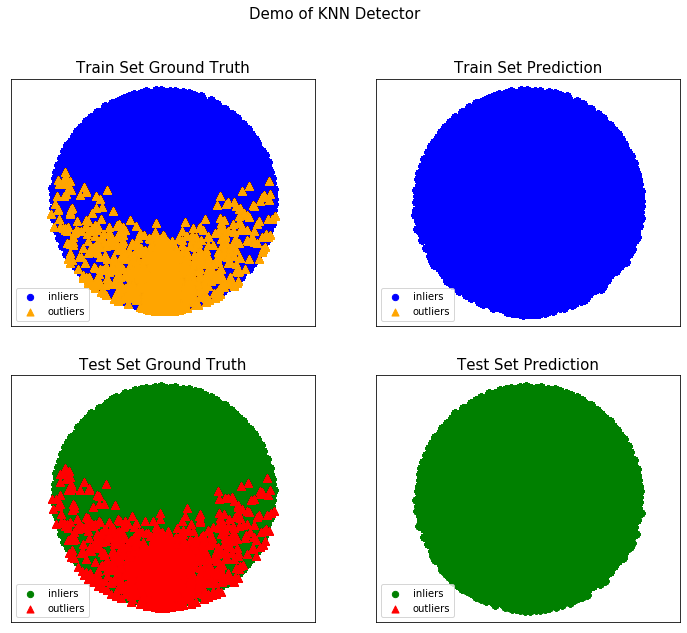

In [12]:
from pyod.utils.example import visualize
visualize(clf_name, X_train_reduced_tsne, y_train, X_test_reduced_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

#### PCA
初始化一个 ``pyod.models.pca.PCA`` 检测器, 模型拟合, 然后给出预测。

In [13]:
# train PCA detector
from pyod.models.pca import PCA

clf_name = 'PCA'
clf = PCA(n_components=3)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

利用 ``ROC`` 和 ``Precision @ Rank`` 评估预测

In [14]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
PCA ROC:0.6463, precision @ rank n:0.1699

On Test Data:
PCA ROC:0.6472, precision @ rank n:0.1726


可视化 ``PCA`` 的结果

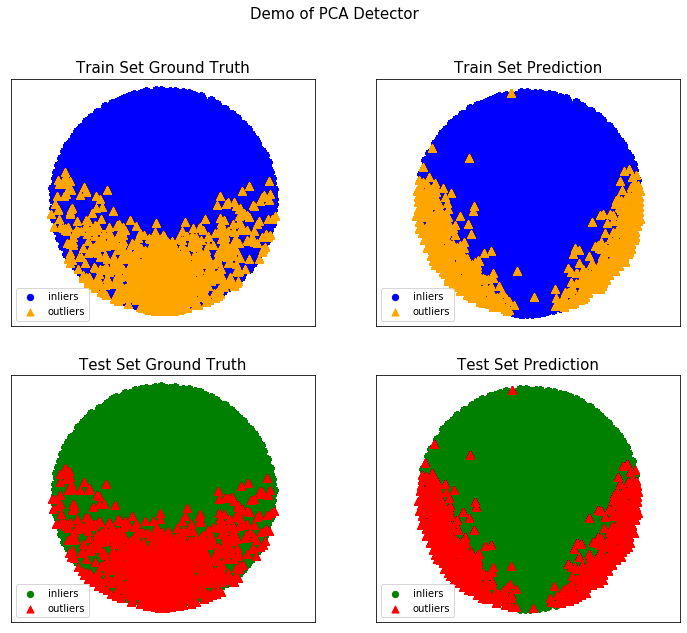

In [15]:
visualize(clf_name, X_train_reduced_tsne, y_train, X_test_reduced_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

#### LOF
初始化一个 ``pyod.models.lof.LOF`` 检测器, 模型拟合, 然后给出预测。

In [16]:
# train LOF detector
from pyod.models.lof import LOF
clf_name = 'LOF'
clf = LOF()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

利用 ``ROC`` 和 ``Precision @ Rank`` 评估预测

In [17]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
LOF ROC:0.5, precision @ rank n:0.0

On Test Data:
LOF ROC:0.5, precision @ rank n:0.0


可视化 ``LOF`` 的结果

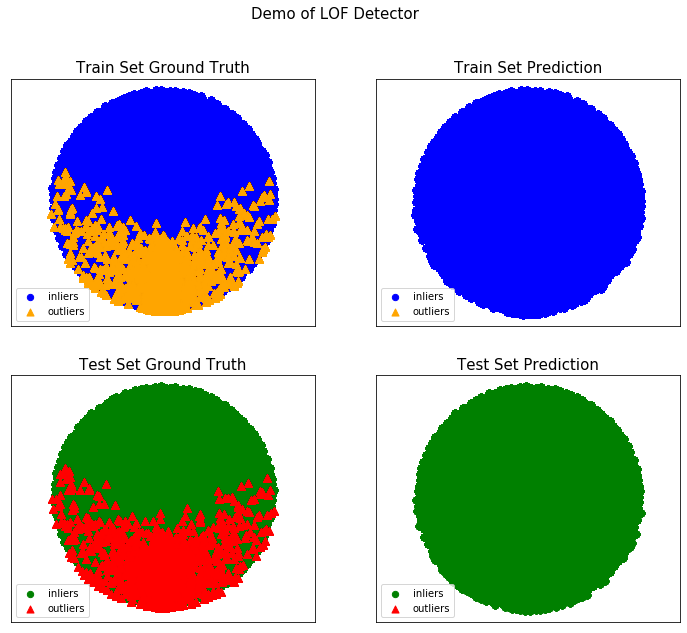

In [18]:
# visualize the results
visualize(clf_name, X_train_reduced_tsne, y_train, X_test_reduced_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

#### Model Combination
用不同的k(10 ～ 200)初始化20个 ``kNN`` 离群点检测器，然后得到所有的离群点的分数。

In [19]:
from pyod.models.knn import KNN  # kNN detector
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

In [20]:
# standardizing data for processing
X_train_norm, X_test_norm = standardizer(X_train, X_test)

n_clf = 20  # number of base detectors

# initialize 20 base detectors for combination
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

print('Combining {n_clf} kNN detectors'.format(n_clf=n_clf))

for i in range(n_clf):
    k = k_list[i]

    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm)

Combining 20 kNN detectors


In [21]:
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

# Combination by average
y_by_average = average(test_scores_norm)
# Combination by max
y_by_maximization = maximization(test_scores_norm)
# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)

In [22]:
print("\nOn Test Data:")
evaluate_print('Combination by Average', y_test, y_by_average)
evaluate_print('Combination by Maximization', y_test, y_by_maximization)
evaluate_print('Combination by AOM', y_test, y_by_aom)
evaluate_print('Combination by MOA', y_test, y_by_moa)


On Test Data:
Combination by Average ROC:0.8717, precision @ rank n:1.0
Combination by Maximization ROC:0.8717, precision @ rank n:1.0
Combination by AOM ROC:0.8717, precision @ rank n:1.0
Combination by MOA ROC:0.8717, precision @ rank n:1.0


In [23]:
m, s = divmod(time.time()-timekeeping, 60)
h, m = divmod(m, 60)
print ('run time: %02d:%02d:%02d' % (h, m, s))

run time: 04:50:18


**2020.6.30 update**

对每个csv文件分开处理，每个csv文件训练一个model并测试结果

In [24]:
# evaluate using ROC and precision @ rank n

from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.metrics import roc_auc_score

from pyod.utils.utility import precision_n_scores
import numpy as np

def evaluate(y, y_pred):
    y = column_or_1d(y)
    y_pred = column_or_1d(y_pred)
    check_consistent_length(y, y_pred)

#     print('ROC:{roc}, precision @ rank n:{prn}'.format(
#         roc=np.round(roc_auc_score(y, y_pred), decimals=4),
#         prn=np.round(precision_n_scores(y, y_pred), decimals=4)))
    
    return np.round(roc_auc_score(y, y_pred), decimals=4), np.round(precision_n_scores(y, y_pred), decimals=4)

In [25]:
# tSNE dimension reduction for visualization

from sklearn.manifold import TSNE

def tsne(original_data):
    # T-SNE Implementation
    t0 = time.time()
    reduced_tsne = TSNE(n_components=2, random_state=2020, init='pca').fit_transform(original_data.values)
    t1 = time.time()
    print("T-SNE took {:.2} s".format(t1 - t0))
    return reduced_tsne

In [26]:
# fit model in unsupervised manner and predict 

def model_evaluation(clf, data):
    
    X_train, y_train = data_label_split(data)
    
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    
    
    roc, prn = evaluate(y_train, y_train_scores)
    
    
    return y_train_pred, roc, prn

In [27]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def visualization(data, y_pred):
    
    X_train, y_train = data_label_split(data)
    X_reduced_tsne = tsne(X_train)
    
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))


    blue_patch = mpatches.Patch(color='#0A0AFF', label='nominal')
    red_patch = mpatches.Patch(color='#AF0000', label='anomaly')
    
     # true visualization
    ax0.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 0), cmap='coolwarm', label='nominal', linewidths=2)
    ax0.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 1), cmap='coolwarm', label='anomaly', linewidths=2)
    ax0.set_title('ground-truth t-SNE visualization', fontsize=14)

    ax0.legend(handles=[blue_patch, red_patch])
    ax0.set_xticks([])
    ax0.set_yticks([])

    # predicted visualization
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_pred == 0), cmap='coolwarm', label='nominal', linewidths=2)
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_pred == 1), cmap='coolwarm', label='anomaly', linewidths=2)
    ax1.set_title('prediction t-SNE visualization', fontsize=14)

    ax1.legend(handles=[blue_patch, red_patch])
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    plt.show()

99 wave_benchmark_0650.csv
best model: KNN ROC: 0.6631 precision @ rank n: 0.0625
T-SNE took 5.3 s


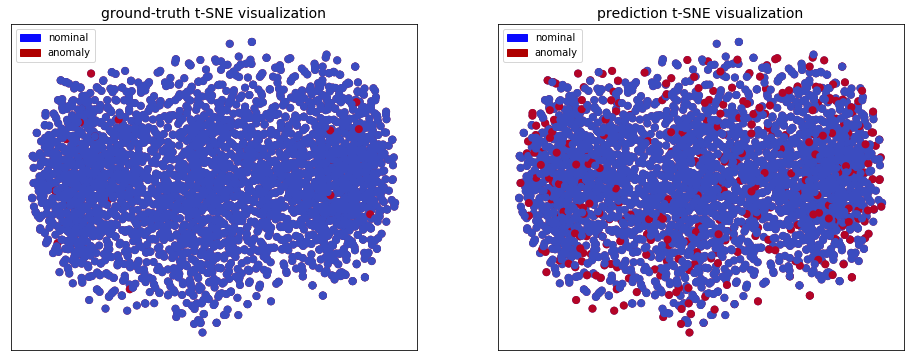

199 wave_benchmark_0676.csv
best model: KNN ROC: 0.5597 precision @ rank n: 0.0
T-SNE took 5.9 s


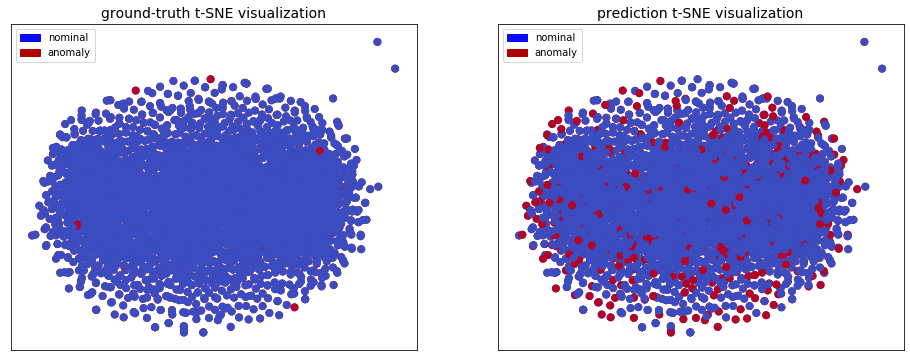

299 wave_benchmark_0661.csv
best model: LOF ROC: 0.7718 precision @ rank n: 0.0625
T-SNE took 5.1 s


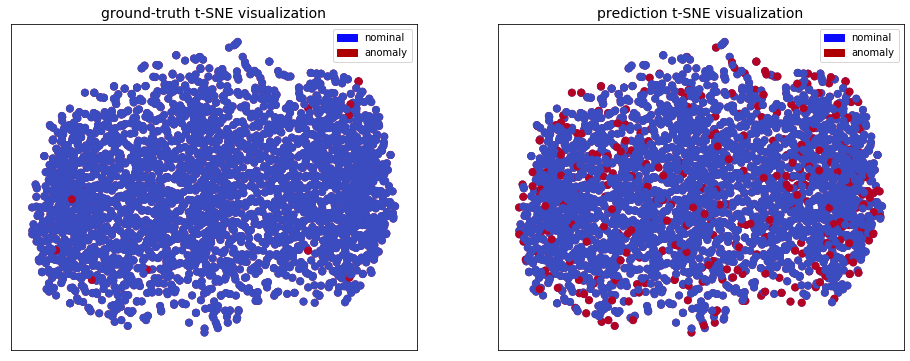

399 wave_benchmark_1234.csv
best model: PCA ROC: 0.6585 precision @ rank n: 0.1195
T-SNE took 5.8 s


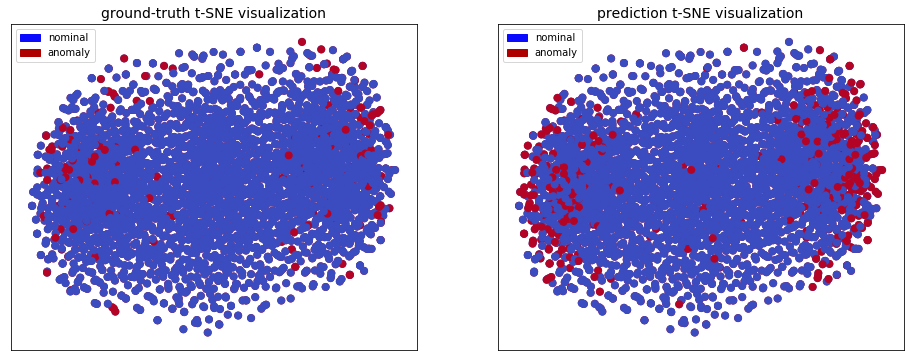

499 wave_benchmark_0659.csv
best model: LOF ROC: 0.6881 precision @ rank n: 0.0625
T-SNE took 5.8 s


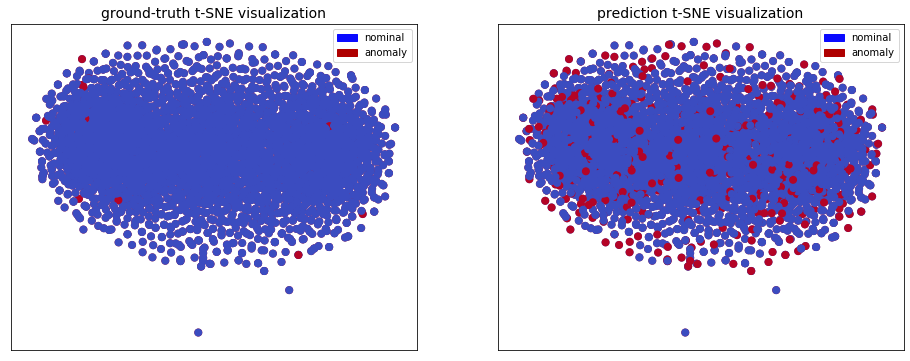

599 wave_benchmark_0323.csv
best model: LOF ROC: 0.8845 precision @ rank n: 0.0
T-SNE took 5.2 s


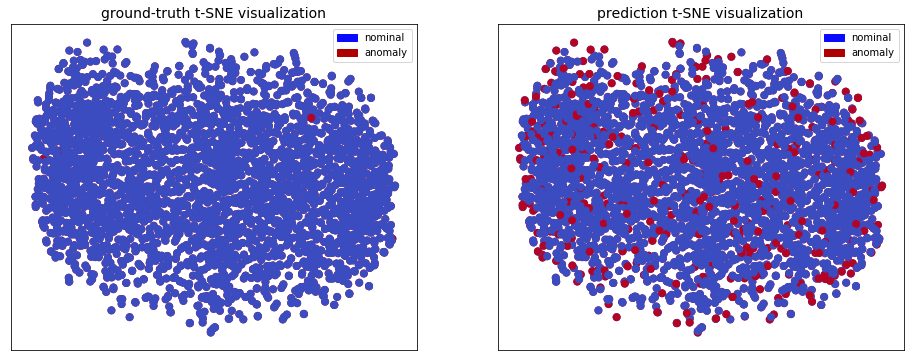

699 wave_benchmark_0104.csv
best model: LOF ROC: 0.528 precision @ rank n: 0.331
T-SNE took 4.5 s


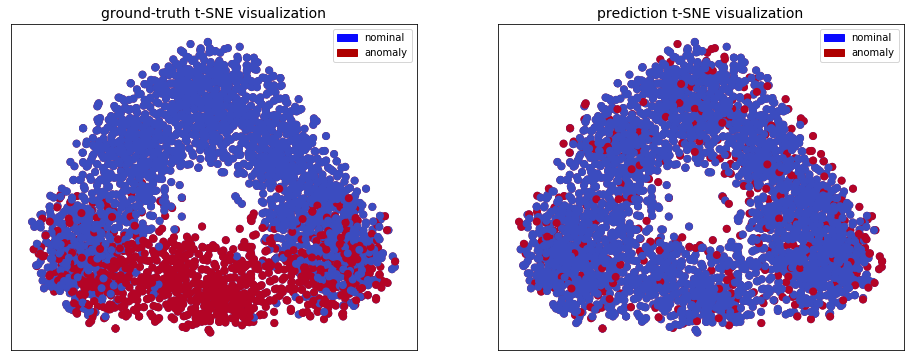

799 wave_benchmark_0621.csv
best model: KNN ROC: 0.7867 precision @ rank n: 0.0625
T-SNE took 5.2 s


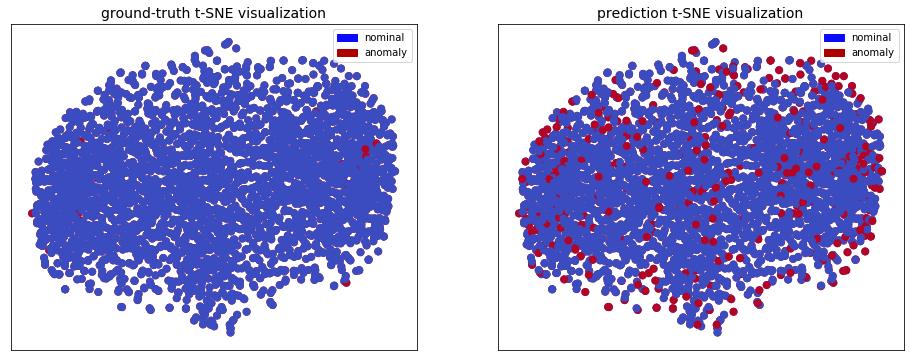

899 wave_benchmark_1005.csv
best model: LOF ROC: 0.7417 precision @ rank n: 0.1935
T-SNE took 5.1 s


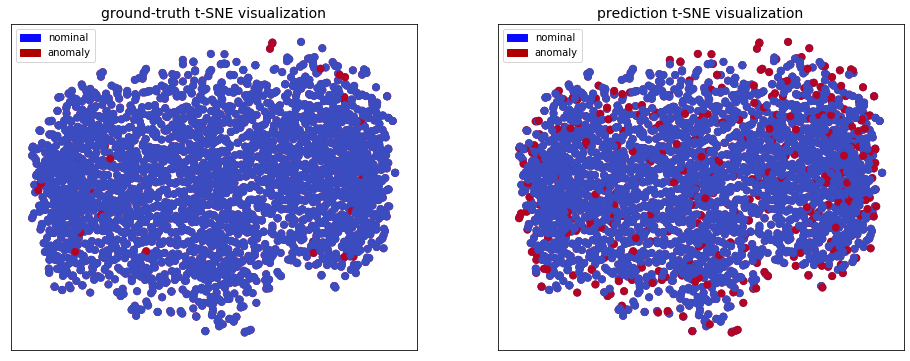

999 wave_benchmark_0283.csv
best model: PCA ROC: 0.5099 precision @ rank n: 0.5533
T-SNE took 0.66 s


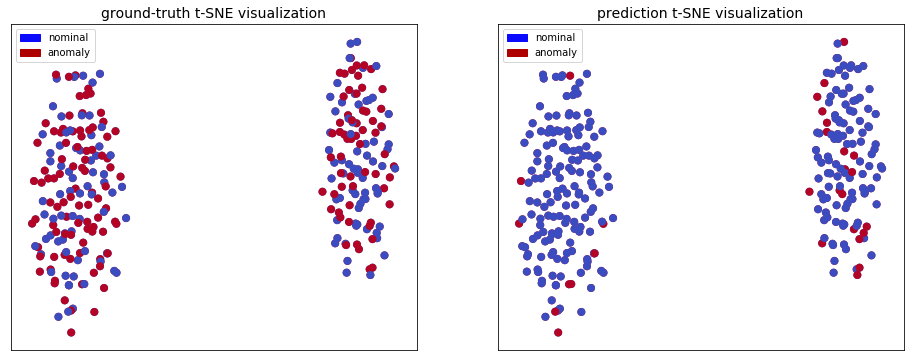

+-------------------------+-------+--------+--------------------+
|         csv_file        | model |  ROC   | precision @ rank n |
+-------------------------+-------+--------+--------------------+
| wave_benchmark_1317.csv |  KNN  | 0.5977 |       0.1132       |
| wave_benchmark_1317.csv |  PCA  | 0.5684 |       0.0566       |
| wave_benchmark_1317.csv |  LOF  | 0.5772 |       0.0943       |
| wave_benchmark_0057.csv |  KNN  | 0.5009 |       0.3282       |
| wave_benchmark_0057.csv |  PCA  | 0.4928 |       0.3354       |
| wave_benchmark_0057.csv |  LOF  | 0.5058 |       0.3262       |
| wave_benchmark_1260.csv |  KNN  | 0.6108 |       0.0881       |
| wave_benchmark_1260.csv |  PCA  | 0.5892 |       0.0818       |
| wave_benchmark_1260.csv |  LOF  | 0.6084 |       0.0881       |
| wave_benchmark_0942.csv |  KNN  | 0.666  |       0.1613       |
| wave_benchmark_0942.csv |  PCA  | 0.6446 |        0.0         |
| wave_benchmark_0942.csv |  LOF  | 0.658  |       0.1935       |
| wave_ben

In [30]:
from pyod.models.knn import KNN
from pyod.models.pca import PCA
from pyod.models.lof import LOF
import prettytable as pt

# Add or replace models
model_list = {'KNN': KNN(), 'PCA': PCA(), 'LOF': LOF()}

tb = pt.PrettyTable( ['csv_file', 'model', 'ROC', 'precision @ rank n'])
for i in range(len(benchmark_list)):
    
    df = pd.read_csv(os.path.join(PAGEB_ROOT, benchmark_list[i]))
    
    df = df.drop(['point.id', 'motherset', 'origin', 'original.label', 'diff.score'], axis=1)

    best_roc = 0
    best_model = None
    best_pred = None
    best_prn = None
    for model in model_list:
        y_train_pred, roc, prn = model_evaluation(model_list[model], df)
        tb.add_row([benchmark_list[i], model, roc, prn])
        if roc >= best_roc:
            best_roc = roc
            best_pred = y_train_pred
            best_model = model
            best_prn = prn
    
    if (i + 1) % 100 == 0:
        # visualize once / 100 files
        print(i, benchmark_list[i])
        print('best model:', best_model, 'ROC:', best_roc, 'precision @ rank n:', best_prn)
        visualization(df, best_pred)

print(tb)

In [31]:
m, s = divmod(time.time()-timekeeping, 60)
h, m = divmod(m, 60)
print ('run time: %02d:%02d:%02d' % (h, m, s))

run time: 13:31:52
